# Angagement analysis

In [11]:

import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc
from scipy.spatial import distance
from scipy.stats import pearsonr,zscore

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

Computation subject list 

In [12]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)





esempio su come fare loading etc..

In [13]:
sv.saving(subject_list, 'subject_list')

In [15]:
enggg=sv.loading('data_engagement/engagement')

Definition of important functions

In [16]:
def transprob(aval):  # (t,r)
    nregions = len(aval.T)
    mat = np.zeros((nregions, nregions))
    norm = np.sum(aval, axis=0)
    for t in range(len(aval) - 1):
        ini = np.where(aval[t] == 1)
        mat[ini] += aval[t + 1]
    mat[norm != 0] = mat[norm != 0] / norm[norm != 0][:, None]
    return mat

def Transprob(ZBIN):  # (t,r)
    nregions = len(ZBIN.T)
    mat = np.zeros((nregions, nregions))
    A = np.sum(ZBIN, axis=1)
    a = np.arange(len(ZBIN))
    idx = np.where(A != 0)[0]
    aout = np.split(a[idx], np.where(np.diff(idx) != 1)[0] + 1)
    ifi = 0
    for iaut in range(len(aout)):
        if len(aout[iaut]) > 2:
            mat += transprob(ZBIN[aout[iaut]])
            ifi += 1
    mat = mat / ifi
    return mat


In [17]:
def bars(p, bottom, top):
    # Get info about y-axis
    yrange = top - bottom

    # Columns corresponding to the datasets of interest
    x1 = 1
    x2 = 2
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level

    if p < 0.001:
        sig_symbol = '*'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')
    plt.ylim((bottom-top/8, top+top/4))

def bars_diff(p, bottom, top,x1=1, x2=2, height=1):
    # Get info about y-axis
    yrange = top - bottom

    # Columns corresponding to the datasets of interest
    
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (yrange * 0.08 * level)*height + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level

    if p < 0.001:
        sig_symbol = '*'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')
    #plt.ylim((-0.24,0.44))

    
def Gtest(a,b,N=5000):
    nsubs=len(a)
    diff=a-b
    diff_bin=np.where(diff>0,1,0)
    observed=np.sum(diff_bin)
    pool=[]
    for i in range(N):
        pool.append(np.sum(np.random.randint(2, size=nsubs)))
    if observed<np.mean(pool):
        p=np.sum(np.asarray(pool)<observed)/N
    else:
        p=np.sum(np.asarray(pool)>observed)/N
    return p


In [7]:

#PARAMETERS

final_channels_without_H={}

final_channels_H={}

final_channels_all={}

dataused='simple'

datatipe="hgenv_down100"

zdata={}
ch_H_i={}
ch_H_w_i={}
cha_i={}

for isub, subject in enumerate(subject_list):
    cha_i[subject]={}
    
    zdata[subject]={}

    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
        print(f.keys())
        print('chnames', f['chnames'].shape)

        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']

    #Here we load the list of bad channels
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        print(f.keys())
        print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices

    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    
    #List of indices of H channels, list of indices of not H channels
    ch_H_i[subject]= [i for i, ch in enumerate(chnames) if ch in ch_H]
    ch_H_w_i[subject]= [i for i, ch in enumerate(chnames) if ch not in ch_H]

    #dictionaries with subjects ad keys and channels names
    final_channels_without_H[subject]=[ch for i, ch in enumerate(chnames) if i not in ch_H_i[subject]]
    final_channels_H[subject]=[ch for i, ch in enumerate(chnames) if i in ch_H_i[subject]]
    final_channels_all[subject]=chnames

    #The final channels that we used

    

    if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
        chnames = np.array([x.replace('Ip', "IP") for x in chnames])
        chnames = np.array([x.replace('p', "'") for x in chnames])
        chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     

    _, _, left_i, right_i = mp.split_hemis(chnames)

    cha_i[subject]['H']=[i for i, ch in enumerate(chnames) if ch in ch_H]
    cha_i[subject]['non_H']=[i for i, ch in enumerate(chnames) if ch not in ch_H]
    cha_i[subject]['left']=left_i
    cha_i[subject]['right']=right_i

    final_channels=chnames

    for sound in ['speech', 'music', 'rest']:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            #if sound=='rest':
                #index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                #data_raw=np.delete(data_raw, index_del, axis=1)

            #data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        
        clean= np.delete(data_raw, ch_i, axis=0)

        


        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, ch_H_w_i[subject], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_i[subject], axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
                
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)
        
    
#sv.saving(zdata, path+"data_subject_sound_" + datatipe)
#sv.saving(ch_H_i, path+"H_channels_indices_subjects")



<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (107,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (21,), type "|S12">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (150,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (29,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (170,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (47,), type "|S10">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (150,)
<KeysViewHDF5 ['dominance', 'implantation',

In [8]:
zb={}
for sound in sound_list:
    zb[sound]={}

    for subject in subject_list:
        thres=np.percentile(zdata[subject]['rest'], 99)

        aval=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        zb[sound][subject]=aval['Zbin']

In [9]:

engagement={}
for sound in sound_list:

    engagement[sound]={}
    for subject in subject_list:

        engagement[sound][subject]=np.sum(zb[sound][subject], axis=0)

sv.saving(engagement, 'engagement')

Little test of our binomial model

In [10]:
vect1=zb['rest'][subject_list[0]][:,1] #this is done with the data, here one can simply use a binned vector. 
vect2=zb['speech'][subject_list[0]][:,0]

eng_random1=[]
eng_random2=[]

for i in range(10000):

    conc=np.concatenate((vect1, vect2))
    np.random.shuffle(conc)

    eng_random1.append(np.sum(conc[:len(vect1)]))
    eng_random2.append(np.sum(conc[len(vect1):]))

eng_real1=np.sum(vect1)
eng_real2=np.sum(vect2)

m=(eng_real1+eng_real2)/2
var=(eng_real1+eng_real2)/4






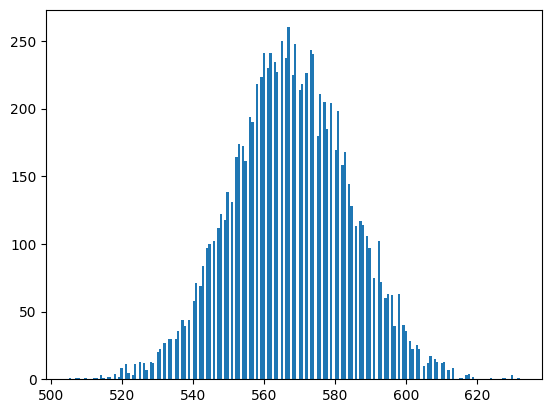

In [9]:
x, y, _ = plt.hist(eng_random1, bins=200)

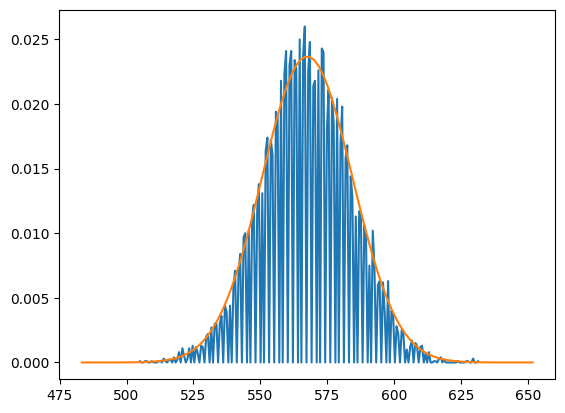

In [10]:
sigma = np.sqrt(var)
xx = np.linspace(m - 5*sigma, m + 5*sigma, 100)
plt.plot(y[:-1],x/10000)
plt.plot(xx, scipy.stats.norm.pdf(xx, m, sigma))

plt.show()

Now, let's do it on the differences:


In [11]:
vect1=zb['rest'][subject_list[0]][:,1]
vect2=zb['speech'][subject_list[0]][:,0]

eng_diff=[]

for i in range(10000):

    conc=np.concatenate((vect1, vect2))
    np.random.shuffle(conc)

    eng_diff.append(np.sum(conc[:len(vect1)])-np.sum(conc[len(vect1):]))

eng_real1=np.sum(vect1)
eng_real2=np.sum(vect2)

eng_real_diff=eng_real1 - eng_real2

m=0
var=(eng_real1+eng_real2)


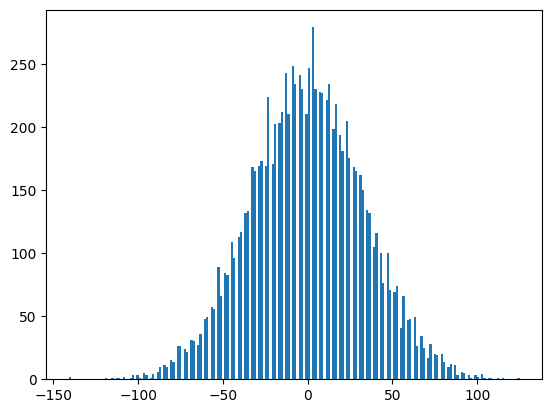

In [12]:
x, y, _ = plt.hist(eng_diff, bins=200)

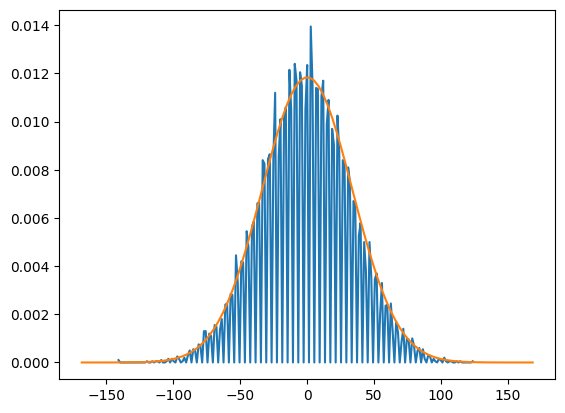

In [13]:
sigma = np.sqrt(var)
xx = np.linspace(m - 5*sigma, m + 5*sigma, 100)
plt.plot(y[:-1],x/20000) # we divide by the double of the simulations done, because only number with a certain parity can be the output of the difference at each simulation.
plt.plot(xx, scipy.stats.norm.pdf(xx, m, sigma))

plt.show()

In [14]:
delta_ae={}

diff_list=[['speech','rest'],['music','rest'],['speech','music']]

for df, diff in enumerate(diff_list):

    delta_ae[df]={}
    sound1,sound2=diff
    for subject in subject_list:

        var=engagement[sound1][subject] + engagement[sound2][subject]
        std=np.sqrt(var)
        delta_ae[df][subject]= (engagement[sound1][subject] - engagement[sound2][subject])/std



Here I prepare some data to be plotted. About asymmetry

In [52]:

std_threshold=3.5
enga_bin={}

for df, diff in enumerate(diff_list):

    enga_bin[df]={}
    enga_bin[df+5]={}

    for subject in subject_list:

        enga_bin[df][subject]=np.where(delta_ae[df][subject]>std_threshold, 1, 0)
        enga_bin[df+5][subject]=np.where(delta_ae[df][subject]< - std_threshold, 1, 0)


In [53]:
enga_per={}

for df, diff in enumerate(diff_list):

    enga_per[df]={}
    enga_per[df+5]={}

    for hemi in ['left','right']:

        enga_per[df][hemi]=[]
        enga_per[df+5][hemi]=[]

        for subject in subject_list:

            enga_per[df][hemi].append(np.sum(enga_bin[df][subject][cha_i[subject][hemi]])/len(cha_i[subject][hemi]))
            enga_per[df+5][hemi].append(np.sum(enga_bin[df+5][subject][cha_i[subject][hemi]])/len(cha_i[subject][hemi]))
        
        enga_per[df][hemi]=np.array(enga_per[df][hemi])
        enga_per[df+5][hemi]=np.array(enga_per[df+5][hemi])
        


In [54]:
en={}

for df, diff in enumerate(diff_list):

    en[df]=[]
    en[df+5]=[]


    for subject in subject_list:

        en[df].append(np.sum(enga_bin[df][subject]))
        en[df+5].append(np.sum(enga_bin[df+5][subject]))
        
    en[df]=np.array(en[df])
    en[df+5]=np.array(en[df+5])

['speech', 'rest']


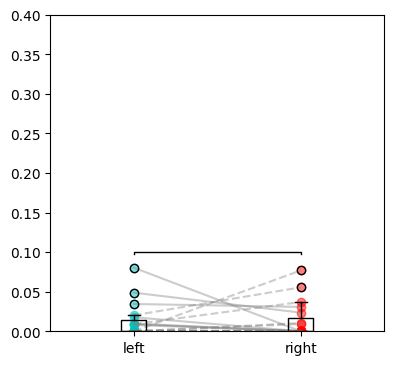

['music', 'rest']


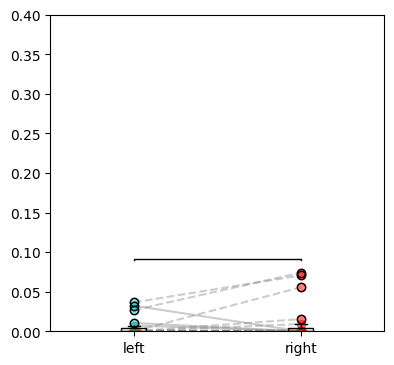

['speech', 'music']


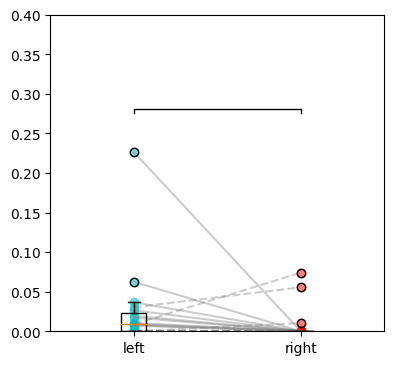

In [55]:
C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}
   
for df, diff in enumerate(diff_list):

    print(diff)
    serie1=enga_per[df]['left']
    serie2=enga_per[df]['right']

    label1='left'
    label2='right'
    plt.figure(figsize=(2.4*1.6,2.8*1.25))

    #plt.axhline(0,alpha=0.3, linestyle=':',color='k')
    box_plot_data=[serie1,serie2]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
    for i in range(len(serie1)):
        point1=serie1[i]
        point2=serie2[i]


        plt.scatter(1,point1,color='c',alpha=.5)#color=C2['sr']
        plt.scatter(2,point2,color='r',alpha=.5)#color=C2['mr'],

        # plt.scatter(1,spre,color=C1['s'],alpha=.5)
        # plt.scatter(2,remu,color=C1['m'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
        # plt.scatter(1,spre,color=C1['r'],alpha=.5)
        # plt.scatter(2,remu,color=C1['r'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
        if point1-point2 >0:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4)
        else:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4,linestyle='--')

 

    plt.boxplot(box_plot_data,patch_artist=False,labels=[label1, label2])
    pp=stats.wilcoxon(serie1,serie2)[1]

    # p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
    # print('Gio test  ', p)
    # print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
    # print('p_value music - speech ', pp)
    # print('p_value music - rest ', psr)
    # print('p_value music - rest ', pmr)

    to_min1=np.array([serie1, serie2])
    bottom1, top1 = np.min(to_min1), np.max(to_min1)
    bars_diff(pp, bottom1, top1,height=3)
    
    plt.tight_layout(pad=0.35)
    plt.ylim((0,0.4))
    plt.show()
    plt.close()

    # plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
    # plt.show()
    # plt.close()

Trying some more metrics

['speech', 'rest']
0.5524933360016062


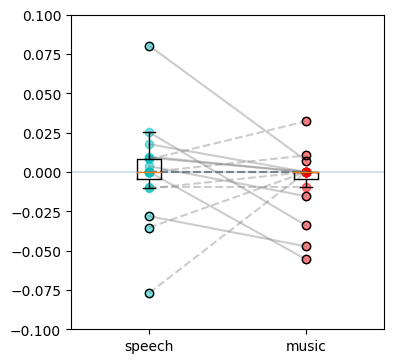

In [56]:
C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}
   
for df, diff in enumerate([['speech', 'rest' ]]):

    print(diff)
    serie1=enga_per[df]['left']-enga_per[df]['right'] 
    serie2=enga_per[df+1]['left']-enga_per[df+1]['right']

    label1='speech'
    label2='music'
    plt.figure(figsize=(2.4*1.6,2.8*1.25))

    #plt.axhline(0,alpha=0.3, linestyle=':',color='k')
    box_plot_data=[serie1,serie2]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
    for i in range(len(serie1)):
        point1=serie1[i]
        point2=serie2[i]


        plt.scatter(1,point1,color='c',alpha=.5)#color=C2['sr']
        plt.scatter(2,point2,color='r',alpha=.5)#color=C2['mr'],

        # plt.scatter(1,spre,color=C1['s'],alpha=.5)
        # plt.scatter(2,remu,color=C1['m'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
        # plt.scatter(1,spre,color=C1['r'],alpha=.5)
        # plt.scatter(2,remu,color=C1['r'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
        if point1-point2 >0:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4)
        else:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4,linestyle='--')

 

    plt.boxplot(box_plot_data,patch_artist=False,labels=[label1, label2])
    pp=stats.wilcoxon(serie1,serie2)[1]
    print(pp)

    # p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
    # print('Gio test  ', p)
    # print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
    # print('p_value music - speech ', pp)
    # print('p_value music - rest ', psr)
    # print('p_value music - rest ', pmr)

    to_min1=np.array([serie1, serie2])
    bottom1, top1 = np.min(to_min1), np.max(to_min1)
    bars_diff(pp, bottom1, top1,height=3)
    plt.axhline(0,alpha=0.2)
    plt.tight_layout(pad=0.35)
    plt.ylim((-0.1,0.1))
    plt.show()
    plt.close()

    # plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
    # plt.show()
    # plt.close()

Who is winning the most of the time ? In order : speech or rest ? music or rest ? speech or music ? 


['speech', 'rest']


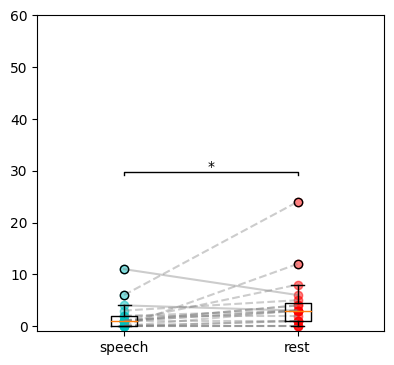

['music', 'rest']


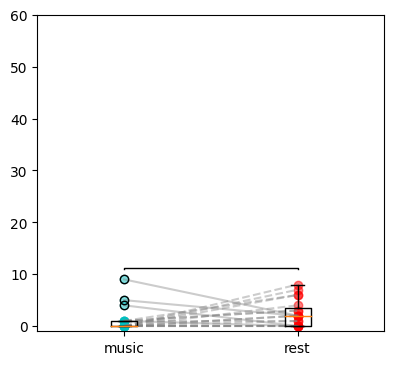

['speech', 'music']


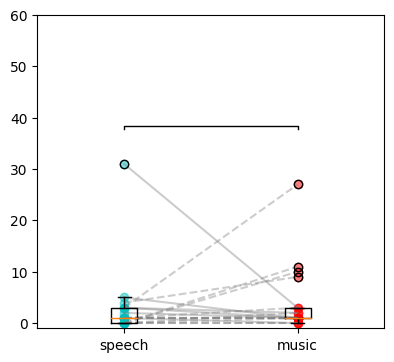

In [59]:
C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}
   
for df, diff in enumerate(diff_list):

    print(diff)
    serie1=en[df]
    serie2=en[df+5]

    label1, label2 = diff
    plt.figure(figsize=(2.4*1.6,2.8*1.25))

    #plt.axhline(0,alpha=0.3, linestyle=':',color='k')
    box_plot_data=[serie1,serie2]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
    for i in range(len(serie1)):
        point1=serie1[i]
        point2=serie2[i]


        plt.scatter(1,point1,color='c',alpha=.5)#color=C2['sr']
        plt.scatter(2,point2,color='r',alpha=.5)#color=C2['mr'],

        # plt.scatter(1,spre,color=C1['s'],alpha=.5)
        # plt.scatter(2,remu,color=C1['m'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
        # plt.scatter(1,spre,color=C1['r'],alpha=.5)
        # plt.scatter(2,remu,color=C1['r'],alpha=.5)
        # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
        if point1-point2 >0:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4)
        else:
            plt.plot([1,2],[point1,point2],color='grey',alpha=0.4,linestyle='--')

 

    plt.boxplot(box_plot_data,patch_artist=False,labels=[label1, label2])
    pp=stats.wilcoxon(serie1,serie2)[1]

    # p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
    # print('Gio test  ', p)
    # print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
    # print('p_value music - speech ', pp)
    # print('p_value music - rest ', psr)
    # print('p_value music - rest ', pmr)

    to_min1=np.array([serie1, serie2])
    bottom1, top1 = np.min(to_min1), np.max(to_min1)
    bars_diff(pp, bottom1, top1,height=3)
    
    plt.tight_layout(pad=0.35)
    plt.ylim((-1,60))
    plt.show()
    plt.close()

    # plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
    # plt.show()
    # plt.close()

The brain plot about where is winning speech vs rest, music vs rest and speech vs music

['speech', 'rest']


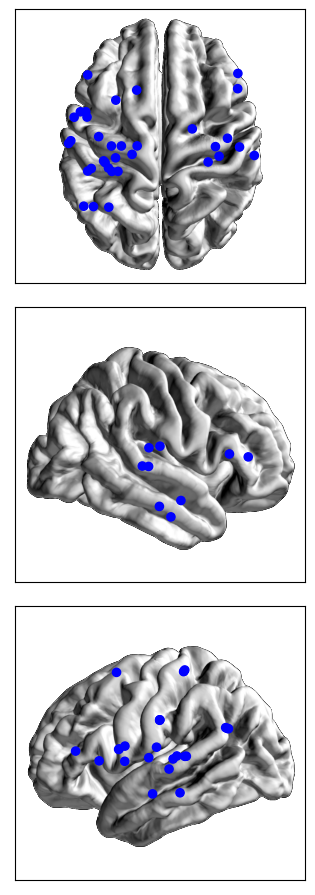

['music', 'rest']


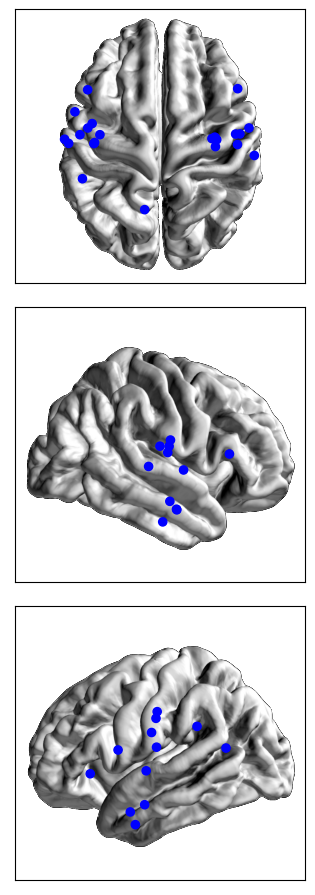

['speech', 'music']


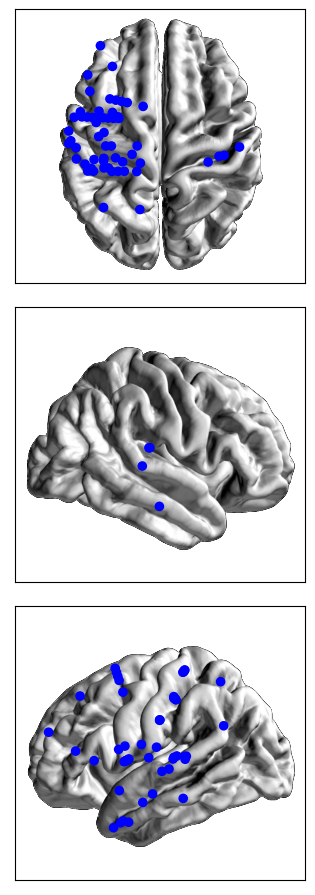

In [65]:


for df, diff in enumerate(diff_list):
    
    print(diff)
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    for j,orientation in enumerate(['top','right','left']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

            im = f[orientation]['imp'][...]
        
        axes=ax[j]

        

    
        for isub,subject in enumerate(subject_list):

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            

            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

            chnames=chnames[ch_i]

            # collect coordinates for this specific orientation (only one patient)
        

            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
            if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
                chnames = np.array([x.replace('Ip', "IP") for x in chnames])
                chnames = np.array([x.replace('p', "'") for x in chnames])
                chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                coordinates=f['mayavi'][orientation]['xy'][...]

            coordinates=coordinates[ch_i]

            _, _, left_i, right_i = mp.split_hemis(chnames)


           
            

            """ if orientation in ('left', 'right'):

                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))

                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))



            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates"""


            axes.imshow(im)
            if orientation =='left':
                x_h = coordinates[left_i]
                if left_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject][left_i]))

            if orientation =='right':
                x_h = coordinates[right_i]

                if right_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject][right_i]))

            if orientation =='top':
                x_h = coordinates
                axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject]))


            #axes.title.set_text('engagement '+sound)

        axes.set_xticks([])
        axes.set_yticks([])

    plt.tight_layout(pad=0.35)
    plt.show()
    plt.close()
    #plt.savefig(path+'figure/brain_plots_all_channels_left_right_increase'+sound+'.png', dpi=600)subject_list

['speech', 'rest'] where the second one is winning ?


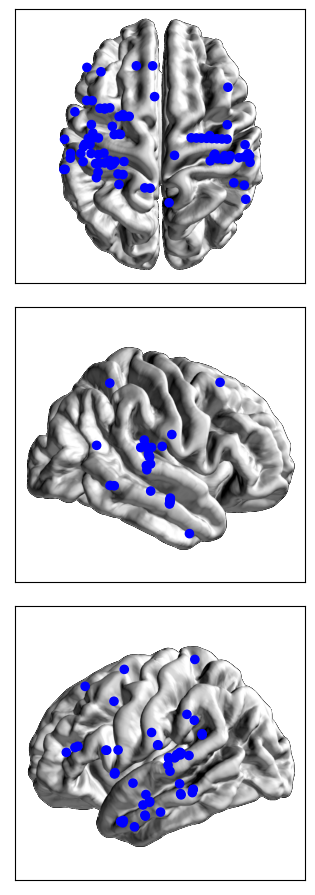

['music', 'rest'] where the second one is winning ?


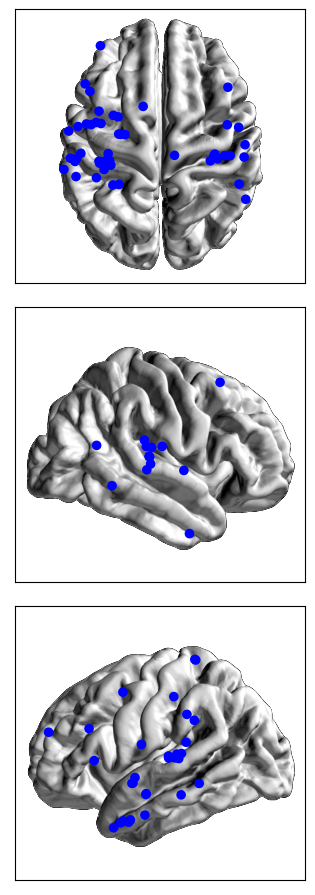

['speech', 'music'] where the second one is winning ?


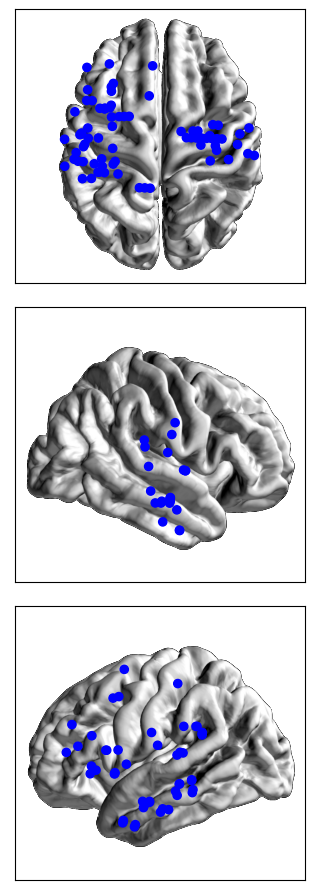

In [67]:


for df, diff in enumerate(diff_list):
    df= df+5
        
    print(diff, 'where the second one is winning ?')
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    for j,orientation in enumerate(['top','right','left']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

            im = f[orientation]['imp'][...]
        
        axes=ax[j]

        

    
        for isub,subject in enumerate(subject_list):

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            

            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

            chnames=chnames[ch_i]

            # collect coordinates for this specific orientation (only one patient)
        

            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
            if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
                chnames = np.array([x.replace('Ip', "IP") for x in chnames])
                chnames = np.array([x.replace('p', "'") for x in chnames])
                chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                coordinates=f['mayavi'][orientation]['xy'][...]

            coordinates=coordinates[ch_i]

            _, _, left_i, right_i = mp.split_hemis(chnames)


           
            

            """ if orientation in ('left', 'right'):

                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))

                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))



            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates"""


            axes.imshow(im)
            if orientation =='left':
                x_h = coordinates[left_i]
                if left_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject][left_i]))

            if orientation =='right':
                x_h = coordinates[right_i]

                if right_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject][right_i]))

            if orientation =='top':
                x_h = coordinates
                axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga_bin[df][subject]))


            #axes.title.set_text('engagement '+sound)

        axes.set_xticks([])
        axes.set_yticks([])

    plt.tight_layout(pad=0.35)
    plt.show()
    plt.close()
    #plt.savefig(path+'figure/brain_plots_all_channels_left_right_increase'+sound+'.png', dpi=600)subject_list